In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from catboost import Pool

In [10]:
tree = ET.parse("./Test_Procody.xml")
root = tree.getroot()

In [11]:
features = []
nucleuses = []
pause_times = []

for sentence in root.findall(".//sentence"):
    elements = list(sentence)

    # сначала определяем индексы фонетических слов (есть nucleus или есть гласная)
    vowels = "аеёиоуыэюяАЕЁИОУЫЭЮЯ"
    phonetic_indices = []
    for idx, el in enumerate(elements):
        if el.tag == "word":
            if any(ch in vowels for ch in el.get("original", "")):
                phonetic_indices.append(idx)

    for i, el in enumerate(elements):
        if el.tag == "word":
            # Исходное слово: (тег <word> → атрибут original)
            original = el.get("original")
            if original is None:
                original = ""
            
            # Знаки препинания и эмфазы на слове (тег <content>, PunktEnd, PunktBeg, EmphEnd, EmphBeg)
            content = elements[i - 1]
            PunktEnd = content.get("PunktEnd")
            PunktBeg = content.get("PunktBeg")
            EmphEnd = content.get("EmphEnd")
            EmphBeg = content.get("EmphBeg")

            # Части речи слов (тег <word> → тег <dictitem>, subpart_of_speech)
            # Формы слова (тег <word> → тег <dictitem>, form)
            # Род и одушевленность слова (тег <word> → тег <dictitem>, genesys)
            # Значения семантики слова (тег <word> → тег <dictitem>, semantics1, semantics2)
            dictitem = el.find("dictitem")
            subpart_of_speech = dictitem.get("subpart_of_speech")
            form = dictitem.get("form")
            genesys = dictitem.get("genesys")
            semantics1 = dictitem.get("semantics1")
            semantics2 = dictitem.get("semantics2")

            # Число слов перед данным словом в предложении
            # Число слов после данного слова в предложении
            # Cлово, предыдущее текущему в предложении
            # Cлово, следующее за текущим в предложении
            # Начинается ли текущее слово с заглавной буквы
            # Порядковый номер слова в предложении
            words_before = sum(1 for j in phonetic_indices if j < i)
            words_after = sum(1 for j in phonetic_indices if j > i)
            prev_word = elements[i - 2].get("original") if i - 2 >= 0 and elements[i - 2].tag == "word" else None
            next_word = elements[i + 2].get("original") if i + 2 < len(elements) and elements[i + 2].tag == "word" else None
            if original != "":
                starts_with_capital = 1 if original[0].isupper() else 0
            else:
                starts_with_capital = 0
                
            position_in_sentence = sum(1 for k in range(i) if elements[k].tag == "word") + 1

            # Фразовое ударение ставится в теге <word> с атрибутом nucleus (значение: 2)
            nucleus = True if el.get("nucleus") == "2" else False

            pause_len = 0
            # смотрим, есть ли после этого слова pause
            if i + 2 < len(elements) and elements[i + 2].tag == "pause":
                pause_time = elements[i + 2].get("time")
                if pause_time is not None and int(pause_time) > 30:
                    pause_len = int(pause_time)

            word_features = {
                "original": original,
                "PunktEnd": PunktEnd,
                "PunktBeg": PunktBeg,
                "EmphEnd": EmphEnd,
                "EmphBeg": EmphBeg,
                "subpart_of_speech": subpart_of_speech,
                "form": form,
                "genesys": genesys,
                "semantics1": semantics1,
                "semantics2": semantics2,
                "words_before": words_before,
                "words_after": words_after,
                "prev_word": prev_word,
                "next_word": next_word,
                "starts_with_capital": starts_with_capital,
                "position_in_sentence": position_in_sentence
            }

            features.append(word_features)
            nucleuses.append(nucleus)
            pause_times.append(pause_len)

In [12]:
features[5]

{'original': 'это',
 'PunktEnd': None,
 'PunktBeg': None,
 'EmphEnd': None,
 'EmphBeg': None,
 'subpart_of_speech': '9',
 'form': '0',
 'genesys': '0',
 'semantics1': None,
 'semantics2': '400',
 'words_before': 4,
 'words_after': 13,
 'prev_word': None,
 'next_word': 'проснуться',
 'starts_with_capital': 0,
 'position_in_sentence': 6}

In [13]:
df = pd.DataFrame(features)
df['nucleus'] = nucleuses
df['pause_len'] = pause_times
df.head()

,original,PunktEnd,PunktBeg,EmphEnd,EmphBeg,subpart_of_speech,form,genesys,semantics1,semantics2,words_before,words_after,prev_word,next_word,starts_with_capital,position_in_sentence,nucleus,pause_len
0,Реально,None,None,None,None,10,0,0,None,None,0,17,None,начать,1,1,False,0
1,начать,None,None,None,None,6,60,0,100,10,1,16,Реально,день,0,2,False,0
2,день,None,None,None,None,1,5,4,None,None,2,15,начать,с,0,3,False,0
3,с,None,None,None,None,9,0,0,None,100,3,15,день,улыбки -,0,4,False,0
4,улыбки -,12,None,None,None,1,2,5,None,None,3,14,с,None,0,5,False,0


In [14]:
# Обработка пропусков в данных
cat_features = ['subpart_of_speech', 'form', 'genesys', 'semantics1', 'semantics2', 'prev_word', 'next_word', 'PunktEnd', 'PunktBeg', 'EmphEnd', 'EmphBeg']

for col in cat_features:
    df[col] = df[col].fillna("")

num_features = ['words_before','words_after','starts_with_capital', 'position_in_sentence']
for col in num_features:
    df[col] = df[col].fillna(0)

In [7]:
# Обучение классификатора определения ударения
X_nucleus = df.drop(columns=['nucleus', 'pause_len', 'original'])
y_nucleus = df['nucleus']
X_train, X_test, y_train, y_test = train_test_split(X_nucleus, y_nucleus, test_size=0.2, random_state=42, stratify=y_nucleus)

clf = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100,
    task_type='GPU'
)

clf.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0:	learn: 0.9504681	test: 0.9540167	best: 0.9540167 (0)	total: 79.6ms	remaining: 39.7s
100:	learn: 0.9850041	test: 0.9849146	best: 0.9856416 (56)	total: 7.39s	remaining: 29.2s
200:	learn: 0.9862310	test: 0.9852781	best: 0.9856416 (56)	total: 14.6s	remaining: 21.7s
300:	learn: 0.9870490	test: 0.9852781	best: 0.9858233 (236)	total: 21.8s	remaining: 14.4s
400:	learn: 0.9877761	test: 0.9854598	best: 0.9858233 (236)	total: 29.3s	remaining: 7.24s
499:	learn: 0.9884577	test: 0.9847328	best: 0.9858233 (236)	total: 36.6s	remaining: 0us
bestTest = 0.985823337
bestIteration = 236
Shrink model to first 237 iterations.
Accuracy: 0.9858233369683751
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      4343
        True       0.97      0.96      0.97      1159

    accuracy                           0.99      5502
   macro avg       0.98      0.98      0.98      5502
weighted avg       0.99      0.99      0.99      5502



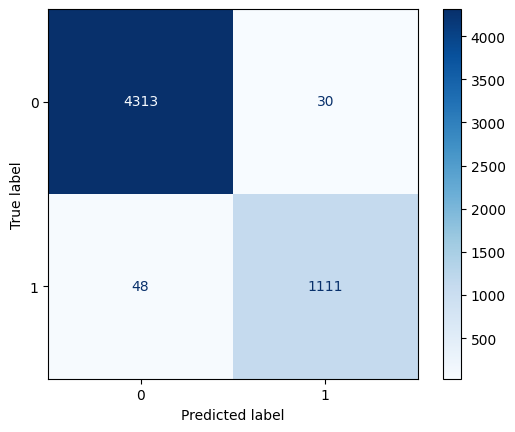

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')

In [9]:
# Обучение предсказателя длины паузы
X_pause = df.drop(columns=['nucleus', 'pause_len', 'original'])
y_pause = df['pause_len']
X_train, X_test, y_train, y_test = train_test_split(X_pause, y_pause, test_size=0.2, random_state=42)

reg = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    early_stopping_rounds=200,
    verbose=100,
    task_type='GPU'
)

reg.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

y_pred = reg.predict(X_test)
y_pred = [0 if i < 30 else i for i in y_pred]
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))

0:	learn: 175.7933317	test: 178.3876329	best: 178.3876329 (0)	total: 45.5ms	remaining: 22.7s
100:	learn: 50.7695161	test: 50.9315226	best: 50.9315226 (100)	total: 4.6s	remaining: 18.2s
200:	learn: 49.6573664	test: 50.4612080	best: 50.4612080 (200)	total: 11.1s	remaining: 16.5s
300:	learn: 49.1537973	test: 50.3347139	best: 50.3347139 (300)	total: 15.8s	remaining: 10.4s
400:	learn: 48.6970727	test: 50.1939912	best: 50.1939912 (400)	total: 20.1s	remaining: 4.96s
499:	learn: 48.2151032	test: 49.9909679	best: 49.9907116 (498)	total: 24.6s	remaining: 0us
bestTest = 49.99071161
bestIteration = 498
Shrink model to first 499 iterations.
RMSE: 49.930043082194004


In [15]:
# Предсказание и сохранение результата в JSON
# Перед запуском стоит запустить заново первые ячейки кода (Кроме ячеек моделей) для загрузки данных, которые нужно предсказывать
predict_pool = Pool(
    data=df[cat_features + num_features],
    cat_features=cat_features
)

# Предсказания
df['pred_nucleus'] = clf.predict(predict_pool)
df['pred_pause_len'] = reg.predict(predict_pool).astype(int)

output = [{
    "words": [
        {
            "content": row['original'],
            "phrasal_stress": row['pred_nucleus'],
            "pause_len": row['pred_pause_len'] if row['pred_pause_len'] > 30 else -1
        }
        for _, row in df.iterrows()
    ]
}]

with open("predictions.json", "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)